In [184]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
%matplotlib inline

In [185]:
tahoe_h = pd.read_csv("Final Project Data_Case.csv")


## relation between variables

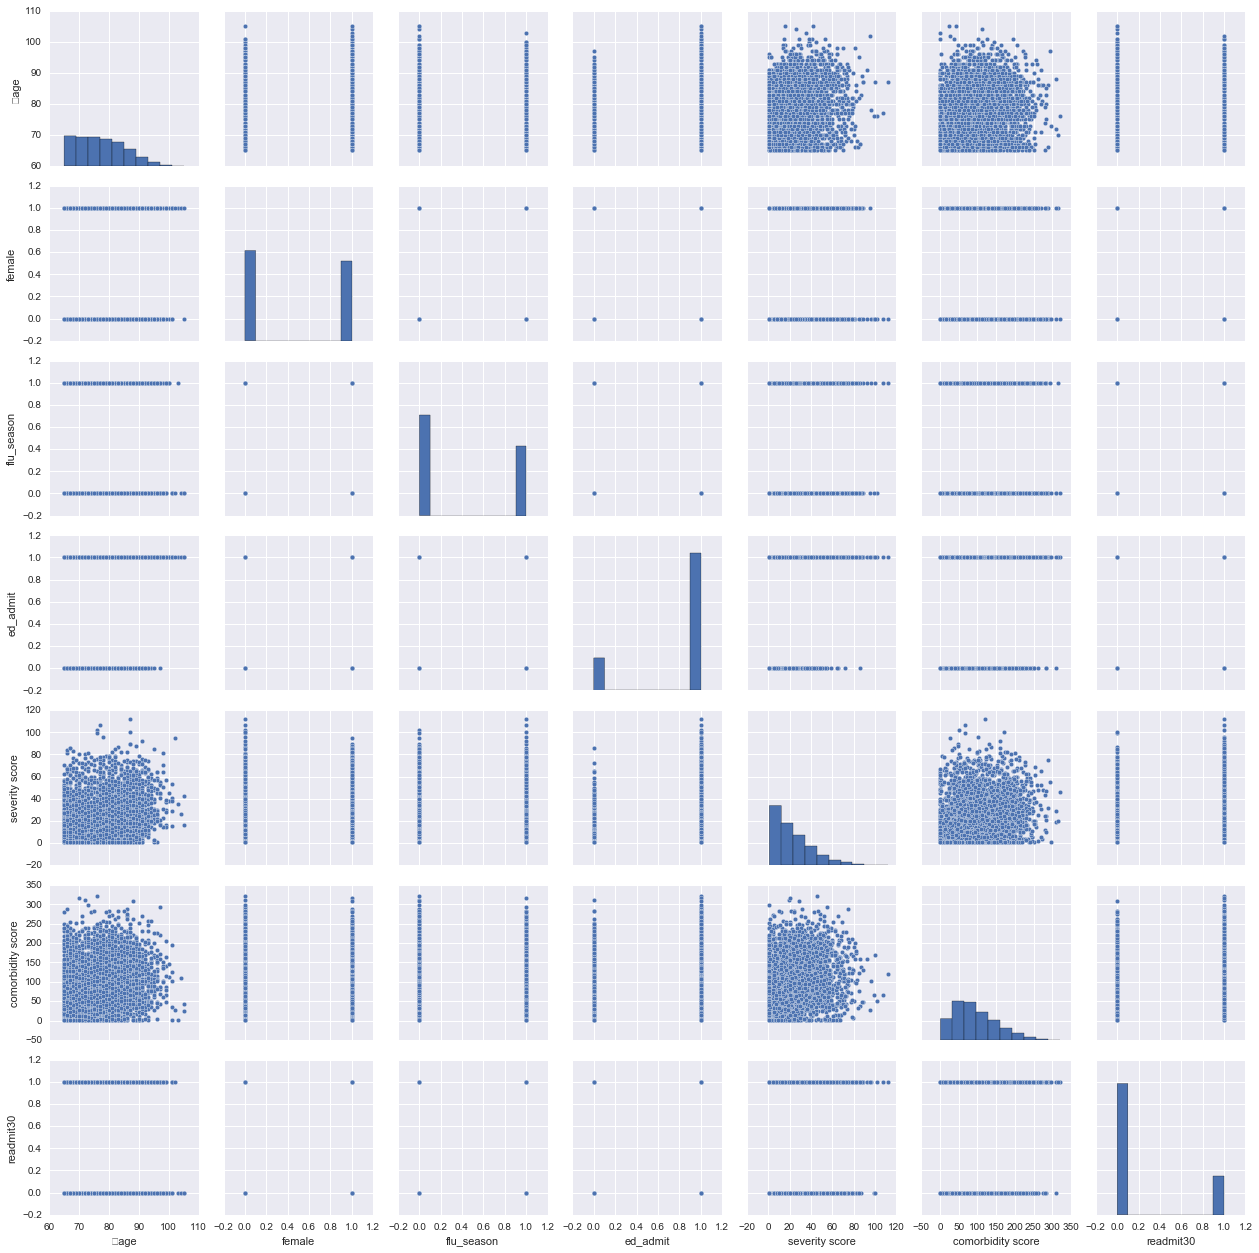

In [186]:
sns.pairplot(tahoe_h)

In [188]:
tahoe_h.head()

,﻿age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


In [189]:
new_columns = tahoe_h.columns.values
new_columns[0] = 'age'
tahoe_h.columns = new_columns

In [190]:
tahoe_h['age'].mean()

76.84732998630763

## patients readmitted

In [191]:
count = 0
for i in tahoe_h['readmit30']:
    if i == 1:
        count+=1
count


998

In [192]:
len(tahoe_h)

4382

## readmission rate for the given data

In [193]:
readm_rate = count / len(tahoe_h)
readm_rate

0.22774988589685075

## readmission rate after calculating risk percentage / score

In [194]:
readm_rate_result = 296 / len(tahoe_h)
readm_rate_result

0.06754906435417618

In [195]:
tahoe_h.corr()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
age,1.000000,0.149257,-0.011575,0.139642,0.281042,0.161160,0.102466
female,0.149257,1.000000,0.014966,0.122485,0.095394,0.005320,0.042248
flu_season,-0.011575,0.014966,1.000000,-0.012863,0.003079,-0.012914,0.121551
ed_admit,0.139642,0.122485,-0.012863,1.000000,0.335556,0.030971,0.054564
severity score,0.281042,0.095394,0.003079,0.335556,1.000000,0.196759,0.250942
comorbidity score,0.161160,0.005320,-0.012914,0.030971,0.196759,1.000000,0.383048
readmit30,0.102466,0.042248,0.121551,0.054564,0.250942,0.383048,1.000000


In [196]:
tahoe_h.describe()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,76.847330,0.469192,0.408033,0.809220,22.353263,94.735509,0.227750
std,7.904949,0.499107,0.491525,0.392961,18.005320,57.145155,0.419428
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,70.000000,0.000000,0.000000,1.000000,8.000000,51.000000,0.000000
50%,76.000000,0.000000,0.000000,1.000000,19.000000,86.000000,0.000000
75%,82.000000,1.000000,1.000000,1.000000,32.000000,131.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.000000


In [197]:
X = tahoe_h.iloc[:,4:6]
X = X.join(tahoe_h['flu_season'])
X = X.values

In [198]:

y = tahoe_h['readmit30'].values


## ElasticNetCV combination of lasso and ridge

In [199]:
elastic = ElasticNetCV(fit_intercept=True, alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.],l1_ratio = [.1, .5, .7, .9, .95, .99, 1])

In [200]:
elastic.fit(X,y)

ElasticNetCV(alphas=[0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0],
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [201]:
coefficients = elastic.coef_
coefficients

array([ 0.00423532,  0.00255931,  0.09737632])

In [202]:
X[0],y[0]

(array([ 38, 112,   1]), 0)

In [203]:
elastic.get_params

<bound method BaseEstimator.get_params of ElasticNetCV(alphas=[0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0],
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)>

In [204]:
print(elastic.coef_)

[ 0.00423532  0.00255931  0.09737632]


In [205]:
elastic.intercept_

-0.1491138488615486

In [206]:
X[len(X)-1]

array([20, 92,  0])

In [207]:
len(X)

4382

## Function to calculate patient risk score

In [208]:
def risk_score(coef,intercept):
    a = []
    risk_scores = []
    for i in range(0,len(X)):
        for i,j in zip(X[i],coef):
            a.append(i*j)
        risk_scores.append(sum(a) + intercept)
        a = []
    return risk_scores
            

In [209]:
len(risk_score(elastic.coef_,elastic.intercept_))

4382

In [210]:
risk_scores = risk_score(elastic.coef_,elastic.intercept_)


## Function to calculate readmission risk percentage

In [211]:
def readmission(score):
    readmission_percentage = []
    for i in score:
        readmission_percentage.append((math.exp(i)/(1+math.exp(i)))*100)
    return readmission_percentage
        
        

In [212]:
readmission_percentage_erl = readmission(risk_scores)
count = 0
for i in readmission_percentage_erl:
    if i > 65.0:
        print(i)
        count+=1
print(count)

66.27905210604116
65.49790400039042
65.95148074932217
67.51179865222035
66.9319211657286
65.13340142539836
65.93041962079127
66.12368089319042
68.1262066502006
66.04499759578188
65.04178953278124
66.24563450766216
68.66687962838559
65.44414274048201
67.49987613087787
68.79197949985749
67.9651705877017
65.25571597227898
67.0040669463429
66.41458029387235
67.30829331329002
65.14111719403967
66.1204315949609
66.40518778317667
67.39395404833748
67.86123670054991
67.94268432840846
67.14132616886722
67.40212052645217
66.55105111755341
65.22870373365387
66.10947508811829
65.95707609175616
65.6691618074423
65.1832773507698
66.11962238804136
65.79873883982287
66.59238056272429
67.4185433869967
65.99673163330077
65.42262594087998
65.80974385030011
67.70543909442266
65.48049834649731
65.44137297172152
66.2268965155068
65.29165300491667
65.81861384375213
71.26268718613896
71.72950700793366
66.75422415836482
65.35855504611138
67.17878913984042
67.52789589175259
66.39406890742949
67.40212052645217
6

## Linear regression

In [213]:
X1 = X

In [214]:
X1 = sm.add_constant(X1)
model = sm.OLS(y,X1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     352.5
Date:                Sat, 04 Mar 2017   Prob (F-statistic):          4.99e-205
Time:                        21:46:40   Log-Likelihood:                -1935.9
No. Observations:                4382   AIC:                             3880.
Df Residuals:                    4378   BIC:                             3905.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1533      0.013    -11.662      0.000      -0.179      -0.127
x1             0.0042      0.000     13.149      0.000       0.004       0.005
x2             0.0026      0.000     25.216      0.000       0.002       0.003
x3             0.1071      0.012      9.251      0.000       0.084       0.130
==============================================================================
Omnibus:                      500.396   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              692.793
Skew:                           0.974   Prob(JB):                    3.65e-151
Kurtosis:                       3.012   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [215]:
results.params

array([-0.15325322,  0.00423758,  0.00256064,  0.10708852])

## ElasticNetCV Ridge regression

In [216]:
elastic_r = ElasticNetCV(fit_intercept=True, alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.],l1_ratio = [0.0001])
elastic_r.fit(X,y)
coefficients_r = elastic_r.coef_

In [217]:
coefficients_r

array([ 0.00423826,  0.00256   ,  0.10181388])

In [218]:
elastic_r.intercept_

-0.15105571152678771

In [219]:
risk_scores_r = risk_score(coefficients_r,elastic_r.intercept_)

In [220]:
readmission_percentage_er = readmission(risk_scores_r)
count = 0
for i in readmission_percentage_er:
    if i > 60.0:
        print(i)
        count+=1
print(count)

60.160916429398135
66.24186905344264
64.88306876569848
62.93684539858339
62.31996826736106
61.74181303506738
62.124726230895476
61.04445624040397
62.41250860842618
60.92897024818298
60.3702708600989
60.169790149388355
65.56077359003282
61.78748629261867
62.55650894771318
64.01983102388378
66.0133931621632
67.476462305824
66.89705570029881
65.09599819275851
61.94786785808203
65.89436139738338
60.47818699225472
66.18548722876972
60.50263612658452
64.88913409533407
61.033872527104336
61.38509676655733
62.4661087000308
60.357392953524744
60.566780535723886
62.44518761527893
64.1180718350979
60.79184825486645
60.719560877562486
63.13261329399348
61.36862204500319
62.31258854954196
60.71613208698696
60.10458425870938
60.796609341756195
68.09138825027475
66.10585132968248
61.14317016759573
62.60272850478161
64.52735167862485
61.88725704103747
60.69376302137777
62.44012119641235
65.00285207496492
62.49277471218211
66.20814439425581
60.210254475147465
60.72401570178035
60.01493583579814
60.0636

## ElasticNetCV Lasso regression

In [221]:
elastic_l = ElasticNetCV(fit_intercept=True, alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.],l1_ratio = [1])
elastic_l.fit(X,y)
coefficients_l = elastic_l.coef_

In [222]:
coefficients_l

array([ 0.00420831,  0.00255288,  0.05532934])

In [223]:
elastic_l.intercept_

-0.13074400687120297

In [224]:
risk_scores_l = risk_score(coefficients_l,elastic_l.intercept_)
risk_scores_l

[0.37042346762815997,
 0.18118628178336199,
 0.13302397564487595,
 0.040004523373434436,
 0.11148514101756302,
 0.43039211764994539,
 0.69154377252666599,
 0.63123272381342233,
 0.54712718528825177,
 0.24321335893715307,
 0.012556779352506486,
 -0.089279438456858123,
 0.052505395134918142,
 0.23326251862123931,
 0.3003193274891266,
 -0.06016084066987909,
 0.097283666822811671,
 0.47453361438542446,
 0.33421955875108506,
 0.10749233587310969,
 0.45018122406614508,
 0.39285690594227157,
 0.40893215746769435,
 0.082442569919639885,
 0.2426583061858068,
 -0.0244205318478148,
 0.092935884735626251,
 0.23113091255618368,
 -0.02621543473342422,
 0.15633659163850638,
 0.036909169671785813,
 -0.069614381160216565,
 0.23844715146945333,
 0.46639595071840595,
 0.17725692507669083,
 0.27749831580906026,
 -0.010974186213023984,
 0.21802411785684522,
 0.0059350683174212437,
 0.46695100346975232,
 0.52463029853635801,
 0.41645416770159033,
 0.25105664634321556,
 0.0046191914941022261,
 0.393417654205

In [225]:
readmission_percentage_el = readmission(risk_scores_l)
count = 0
for i in readmission_percentage_el:
    if i > 60.0:
        print(i)
        count+=1
print(count)

60.596729861763286
66.6310258602148
65.27689260065218
63.34688195605062
61.6456239256233
61.06823207306705
60.083180262299344
61.45303723060238
61.46618463912446
62.82298459854056
60.26344527753697
60.5981768205954
64.90037648202926
61.117526479324134
62.98118556835335
60.33450807337029
63.361307616484474
65.36280934745314
67.84659375993095
67.26259977416788
65.4877052585786
61.27807805369262
66.27224844321888
60.90585475450673
65.53599507055608
60.94569934880661
64.24104585230839
60.37085026173506
60.7015719260119
61.80908144520125
60.36077109147983
62.86348144279445
63.44741494219518
61.22260204841653
60.086525288329405
60.03640835712981
62.47114863291138
61.800998641229
61.659245957233566
60.05692334571812
61.21741818640316
68.45610049188548
65.46611319599498
61.56251093087069
61.94411355481941
63.85763018021411
62.299331920534485
60.020113756254744
61.766271428947526
65.41009510030334
61.84013848706809
66.60041413290023
61.16385157727811
60.449965329366925
63.497259816873864
60.581

## EDA

In [226]:
df_admit = tahoe_h.groupby(['ed_admit','readmit30']).size()
df_admit

ed_admit  readmit30
0         0             685
          1             151
1         0            2699
          1             847
dtype: int64

In [227]:
df_flu = tahoe_h.groupby(['flu_season','readmit30']).size()
df_flu

flu_season  readmit30
0           0            2113
            1             481
1           0            1271
            1             517
dtype: int64

In [228]:
df_female = tahoe_h.groupby(['female','readmit30']).size()

## Graph showing importance of ed_admit

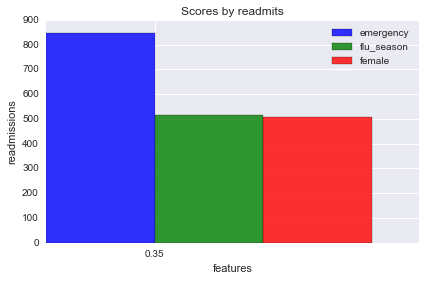

In [229]:
n_groups = 1
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index,df_admit.values[3] , bar_width,
                 alpha=opacity,
                 color='b',
                 label='emergency')
 
rects2 = plt.bar(index + bar_width, df_flu.values[3], bar_width,
                 alpha=opacity,
                 color='g',
                 label='flu_season')

rects3 = plt.bar(index + bar_width + bar_width, df_female.values[3], bar_width,
                 alpha=opacity,
                 color='r',
                 label='female')


 
plt.xlabel('features')
plt.ylabel('readmissions')
plt.title('Scores by readmits')
plt.xticks(index + bar_width)
plt.legend()
 
plt.tight_layout()
plt.show()

In [230]:
tahoe_h.groupby(['ed_admit','flu_season','readmit30']).size()

ed_admit  flu_season  readmit30
0         0           0             419
                      1              65
          1           0             266
                      1              86
1         0           0            1694
                      1             416
          1           0            1005
                      1             431
dtype: int64

In [231]:
df = tahoe_h.groupby(['ed_admit','flu_season','readmit30']).size()

## graph showing ed and flu cases , ed has more impact

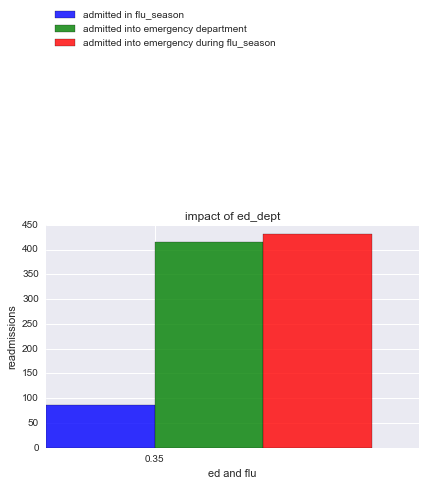

In [232]:
n_groups = 1
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index,df.values[3] , bar_width,
                 alpha=opacity,
                 color='b',
                 label='admitted in flu_season')
 
rects2 = plt.bar(index + bar_width, df.values[5], bar_width,
                 alpha=opacity,
                 color='g',
                 label='admitted into emergency department')

rects3 = plt.bar(index + bar_width + bar_width, df.values[7], bar_width,
                 alpha=opacity,
                 color='r',
                 label='admitted into emergency during flu_season')


 
plt.xlabel('ed and flu')
plt.ylabel('readmissions')
plt.title('impact of ed_dept')
plt.xticks(index + bar_width)
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.rcParams.update({'font.size': 10})
 
plt.tight_layout()
plt.show()

In [233]:
tahoe_h.groupby(['severity score','readmit30']).describe()

age  comorbidity score    ed_admit  \
severity score readmit30                                                    
1              0         count  405.000000         405.000000  405.000000   
                         mean    73.103704          76.254321    0.340741   
                         std      6.330745          43.177930    0.474545   
                         min     65.000000           1.000000    0.000000   
                         25%     68.000000          47.000000    0.000000   
                         50%     72.000000          71.000000    0.000000   
                         75%     78.000000          99.000000    1.000000   
                         max     95.000000         215.000000    1.000000   
               1         count   76.000000          76.000000   76.000000   
                         mean    75.881579         124.750000    0.223684   
                         std      6.842937          62.371388    0.419482   
                         min     65.000000           1.000000    0.000000   
                         25%     70.750000          84.000000    0.000000   
                         50%     76.000000         128.500000    0.000000   
                         75%     80.000000         163.000000    0.000000   
                         max     96.000000         298.000000    1.000000   
2              0         count   84.000000          84.000000   84.000000   
                         mean    73.142857          82.297619    0.511905   
                         std      6.383606          50.477427    0.502860   
                         min     65.000000           1.000000    0.000000   
                         25%     68.000000          52.750000    0.000000   
                         50%     72.000000          71.500000    1.000000   
                         75%     77.000000         104.750000    1.000000   
                         max     90.000000         261.000000    1.000000   
               1         count   12.000000          12.000000   12.000000   
                         mean    76.000000         130.833333    0.333333   
                         std      5.704862          49.981512    0.492366   
                         min     70.000000          75.000000    0.000000   
                         25%     71.000000          87.000000    0.000000   
                         50%     73.500000         124.500000    0.000000   
...                                    ...                ...         ...   
100            0         std           NaN                NaN         NaN   
                         min     87.000000         170.000000    1.000000   
                         25%     87.000000         170.000000    1.000000   
                         50%     87.000000         170.000000    1.000000   
                         75%     87.000000         170.000000    1.000000   
                         max     87.000000         170.000000    1.000000   
102            1         count    1.000000           1.000000    1.000000   
                         mean    76.000000          50.000000    1.000000   
                         std           NaN                NaN         NaN   
                         min     76.000000          50.000000    1.000000   
                         25%     76.000000          50.000000    1.000000   
                         50%     76.000000          50.000000    1.000000   
                         75%     76.000000          50.000000    1.000000   
                         max     76.000000          50.000000    1.000000   
107            1         count    1.000000           1.000000    1.000000   
                         mean    77.000000          67.000000    1.000000   
                         std           NaN                NaN         NaN   
                         min     77.000000          67.000000    1.000000   
                         25%     77.000000          67.000000    1.000000   
                         50%     77

## Logistic Regression Ridge (The model used for this case , best fit model)

In [234]:
logistic = LogisticRegression(fit_intercept = True)
logistic.fit(X,y)
print(logistic.coef_)
print(logistic.intercept_[0])

[[ 0.02580701  0.01546255  0.72365857]]
-3.83548963981


## function to calculate risk score for logistic

In [235]:
def risk_score_log(coef,intercept):
    a = []
    risk_scores = []
    for i in range(0,len(X1)):
        for i,j in zip(X1[i],coef):
            a.append(i*j)
        risk_scores.append(sum(a) + intercept)
        a = []
    return risk_scores
risk_scores_logis = risk_score(logistic.coef_[0],logistic.intercept_[0])
risk_scores_logis

[-0.39935956091716474,
 -1.9436161007560677,
 -1.8490204272657951,
 -2.4048056104018616,
 -1.9718543389171561,
 -0.42752850538336418,
 1.154877512559664,
 0.7946624207423989,
 0.28429011575310525,
 -1.5672886248061468,
 -2.9640357913734103,
 -3.5827542206876282,
 -2.7217531444628618,
 -1.6177112761513119,
 -0.82174975373634584,
 -3.4076564479773874,
 -2.0654960630081476,
 0.23503802671471696,
 -1.0157550696922373,
 -2.3864786121838093,
 0.08531403935768056,
 -0.65424030042999703,
 -0.5562386418631009,
 -2.5356610672721058,
 -1.1840226681748214,
 -3.1911808122350349,
 -2.0911947677225959,
 -1.2506660101063898,
 -3.2014169715393148,
 -2.0871389439234846,
 -2.8143118040163744,
 -3.4642802435121718,
 -1.5926624101593512,
 0.18320739147082943,
 -1.9696397248317594,
 -1.3554978429009426,
 -2.7199327434335974,
 -1.7163627734406957,
 -3.0054136544055225,
 -0.20005856516049603,
 0.15057020607497673,
 -0.12690996836251545,
 -1.1207645026354265,
 -3.0102068146964189,
 -0.27184079542865502,
 -2.29

## function to calculate readmission risk percentage for logistic

In [236]:
def readmission_log(score):
    readmission_percentage = []
    for i in score:
        readmission_percentage.append((math.exp(i)/(1+math.exp(i)))*100)
    return readmission_percentage

In [237]:
readmission_percentage_logr = readmission_log(risk_scores_logis)
count1 = 0
for i in readmission_percentage_logr:
    if i > 59.99:
        print(i)
        count1+=1
print(count1)

76.04006865321918
68.8831564960521
74.75701270717887
66.2053224729485
76.91693927070739
81.6948968579181
79.28272970268137
70.08595935970513
74.43153583444374
77.73024089757119
71.06897032722627
66.91771293982359
60.835697173632056
84.10283729205635
77.26510137633181
69.27083619625748
69.40600736099366
75.84712597472036
87.55853026467223
62.90373037490903
61.28689562272096
74.45998594682143
64.81040374113185
64.95663095270079
65.0168798155045
81.70461276247059
87.9481794981428
61.647993161765534
61.56230713658898
70.5557359287861
83.46829905455712
70.72354001442977
79.62224894857317
76.79930794450205
80.82952927936259
70.20674662479244
75.4013574849837
79.14594604044972
63.73282087798392
81.1381262369818
63.62697178075874
85.02319234115801
64.46936003305052
85.20128021071339
82.27172402824078
83.21536901209538
63.027644264610394
62.53156146308052
79.72409351546894
64.42965555348968
73.24911963587358
61.08703417365281
77.74336188724212
65.77015602186889
77.02110531295973
62.626539387546

## Patients with high risk of readmission 

In [238]:
count1

279

## Lasso Logistic regression

In [239]:
logistic_l = LogisticRegression(penalty = 'l1',fit_intercept = True)
logistic_l.fit(X,y)
print(logistic_l.coef_)
print(logistic_l.intercept_[0])

[[ 0.02614637  0.01564021  0.73398689]]
-3.87464067042


In [240]:
risk_scores_logil = risk_score(logistic_l.coef_[0],logistic_l.intercept_[0])
risk_scores_logil

[-0.39538778137955077,
 -1.9606863108075665,
 -1.8632902150020008,
 -2.424433757871904,
 -1.9865077394899191,
 -0.42627907580205227,
 1.1743949362053043,
 0.81072605092017769,
 0.29436093344589986,
 -1.5799490642928831,
 -2.99270247261245,
 -3.6187871190634473,
 -2.7475930970573597,
 -1.6296235288276146,
 -0.82233159957720403,
 -3.4418487155599902,
 -2.0822532241929932,
 0.24681312877610795,
 -1.0220353898935182,
 -2.4081663830865394,
 0.095068994111853211,
 -0.65551021203370397,
 -0.55629683447886791,
 -2.5587203958446749,
 -1.1905229481055857,
 -3.2228857063689977,
 -2.1081615661758666,
 -1.2575037982510988,
 -3.2331538334096575,
 -2.1049161381392523,
 -2.8409583379481944,
 -3.4990374874272914,
 -1.6051433331320846,
 0.19404434728546471,
 -1.9873087259341122,
 -1.3651680210973245,
 -2.7440382909050762,
 -1.7302650526697945,
 -3.0347270782999849,
 -0.19538176890183179,
 0.15944713562997803,
 -0.12066414660860136,
 -1.1248677713808193,
 -3.0391470686766429,
 -0.26798829089619858,
 -2.3

In [241]:
readmission_percentage = readmission(risk_scores_logil)
count = 0
for i in readmission_percentage:
    if i > 59.99:
        print(i)
        count+=1
print(count)

76.39385021565546
69.22641997678988
75.1662926986706
66.5620934363431
77.31283275414917
82.05599546224943
79.66760931997982
70.436119860921
74.81074486713885
78.12526451722914
71.43741491786744
67.30705463028748
61.14957310313341
84.45117127496198
77.6421089021282
69.67407345669065
69.72034480050624
76.1952273604891
87.89621960783751
63.246414444441825
61.569124587856095
74.86423866644336
65.16096702570832
65.34213926264766
65.34556127319271
82.07701405003709
88.28323501883122
61.927297090670564
61.873211558963646
70.94511569551145
83.81535785753856
71.06862275382142
80.00965980715709
60.19798712707101
77.17264949576597
81.1911846294439
70.57258552301346
75.78332315007398
79.56251881451465
64.06097155898033
81.48843100397659
63.970120357559736
85.41148896598125
64.83221444762994
85.56712070834956
82.67452287461033
83.59673592792507
63.36531485635679
62.848402128175884
80.12553629775235
64.7453339761103
73.6318276057071
61.41015411513304
78.1537255218682
66.1567880234786
77.431887900925

## These red(logistic) has well defined groups , appropriate range compared to blue(elasticnetCV)

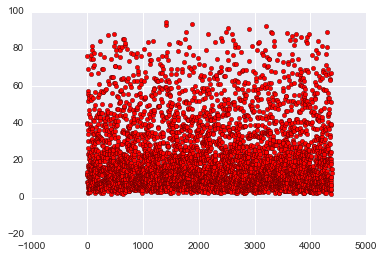

In [242]:
plt.scatter(range(0,len(X)),readmission_percentage_logr,c = 'r')

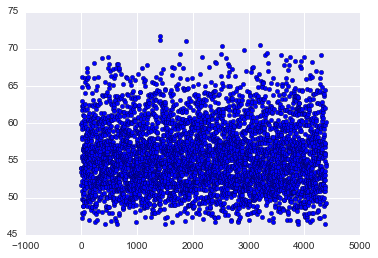

In [243]:
plt.scatter(range(0,len(X)),readmission_percentage_er,c = 'b')

## From the analysis we figure that logistic regression , using l2 penalty as ridge performs the best 

In [244]:
tahoe_h['patient risk score'] = risk_scores_logis

In [245]:
tahoe_h['ERA-AMI(percentage)'] = readmission_percentage_logr

In [246]:
tahoe_h.head()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30,patient risk score,ERA-AMI(percentage)
0,100,1,1,1,38,112,0,-0.399360,40.146622
1,83,1,0,1,8,109,1,-1.943616,12.525113
2,74,0,1,0,1,80,0,-1.849020,13.598795
3,66,1,1,1,25,4,0,-2.404806,8.280698
4,68,1,1,1,25,32,0,-1.971854,12.218985


## Seggregation into risk groups A,B,C

In [247]:
def era_groups(era):
    groups = []
    for i in era:
        if i < 50.0:
            groups.append('C')
        elif i >= 50.0 and i < 60.0:
            groups.append('B')
        else:
            groups.append('A')
    return groups

In [248]:
ERA_group = era_groups(readmission_percentage_logr)

In [249]:
tahoe_h['readmission risk groups'] = ERA_group

In [250]:
tahoe_h.head(20)

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30,patient risk score,ERA-AMI(percentage),readmission risk groups
0,100,1,1,1,38,112,0,-0.399360,40.146622,C
1,83,1,0,1,8,109,1,-1.943616,12.525113,C
2,74,0,1,0,1,80,0,-1.849020,13.598795,C
3,66,1,1,1,25,4,0,-2.404806,8.280698,C
4,68,1,1,1,25,32,0,-1.971854,12.218985,C
5,80,1,0,1,29,172,0,-0.427529,39.471666,C
6,71,1,0,1,31,271,1,1.154878,76.040069,A
7,72,0,0,0,47,221,1,0.794662,68.883156,A
8,69,1,0,1,44,193,0,0.284290,57.059769,B
9,65,1,0,0,10,130,0,-1.567289,17.260326,C


In [251]:
tahoe_h_new = tahoe_h.iloc[:,7:10]

## Magnitude of the percents

## Assuming treatment cost for each patient is 16000 dollars

## Costs if caretracker was not implemented 

In [253]:
(16000 * 4382) + (8000 * 998) 

78096000

## Costs caretracker if it had been implemented for readmitted patients and taking into the fact that caretracker reduces readmissions by 40 percent

In [265]:
(16000 * 4382) + (1200 * 998) + ((998-(0.4 * 998)) * 8000)

76100000.0

## Costs without caretracker for high risk of re-admits

In [262]:
(16000 * 4382) + (8000 * 279) 

72344000

## Costs caretracker only for high risk of re-admits

In [255]:
(16000 * 4382) + (1200 * 279) + ((279 - (0.4 * 279)) * 8000)

71786000.0

## Costs without caretracker for all high risk and medium risk of re-admits

In [264]:
(16000 * 4382) + (8000 * 485) 

73992000

## Costs caretracker for all high and medium risk of readmission

In [256]:
(16000 * 4382) + (1200 * 485) + ((485 - (0.4 * 485)) * 8000)

73022000.0